# Map of Knowledge from arXiv

## Use the arxiv Python Package to Pull Categories

In [3]:
import arxiv

# Create a client
client = arxiv.Client()

# Search with a minimal query that will return papers from various categories
search = arxiv.Search(query="a", max_results=100)

# Get the results
results = client.results(search)

# Extract unique categories from the results
all_categories = set()
for result in results:
    # Each result has a primary_category attribute and categories list
    all_categories.add(result.primary_category)
    all_categories.update(result.categories)

# Print the unique categories
print(sorted(all_categories))

['00A69, 06A06', '08A99, 03G25', '11B13, 11B75', '11B34, 11B83', '11B75; 05A05; 11C08', '12E15, 16D25, 16S32, 16S35, 16S36, 16W50, 17A99', '13-xx, 13Dxx, 16-xx, 17-xx', '13B35, 13C12, 13H15', '13D25; 16E45', '14A22', '15B05, 47A30', '16G10, 16E65, 16G50', '16S99, 46J20', '16T05', '16T10, 16T05, 16S40', '16Yxx', '16Yxx; 12Kxx; 15A03', '17B60', '17B63', '18C20, 18D05', '20C07, 20F19', '20F36, 20F10', '20Mxx', '20Nxx', '20d15', '26B99, 76D99, 78A99', '26E20', '26E60', '26E60 33E05', '28A12, 11B13', '30A10; 30C15', '35Q31', '37E35, 30F35', '39B82, 39B52, 46H25', '46H25, 46L57', '46L05', '46L05, 46L57, 47B47 (Primary), 15A86 (Secondary)', '46L05, 47C15', '46L05; 47B99; 47L30; 16W20', '47H10, 46A03, 46S40', '53C10, 53C56, 53C26', '54A99, 60B99', '55P48, 55P60', '57M25', '58B34', '58B34 (Primary); 37J05, 53C12 (Secondary)', '58E20', 'G.1.2', 'G.1.6', 'Primary 13D09, Secondary 13D02', 'Primary 46L05, Secondary 46L06', 'Primary: 46C05, Secondary: 47A05', 'Primary:46H30, Secondary 47B15', 'astro

In [128]:
import arxiv
from collections import Counter, defaultdict
import numpy as np

# Create a client with appropriate rate limiting
client = arxiv.Client(page_size=100, delay_seconds=3)

total_papers = 2966
papers_per_search = 250

# Exclude sub-categories from Math papers categories
# Only keep categories that start with the below
category_taxonomy_prefix = ['cs', 'econ', 'eess',
                            'math', 'astro-ph',
                            'cond-mat', 'gr-qc',
                            'hep', 'nlin', 'nucl',
                            'physics', 'quant',
                            'q-bio', 'q-fin',
                            'stat']

# Collect papers and their categories
papers = []
categories = set()

for i in range(int(np.ceil((total_papers * 1.1) / papers_per_search))):
    # Search for a diverse set of papers
    search = arxiv.Search(
        query="a",  # Empty query returns diverse results
        max_results=papers_per_search  # Seems to cap around 250
        # sort_by=arxiv.SortCriterion.SubmittedDate
    )

    for paper in client.results(search):
        paper_cats = list(paper.categories)
        paper_cats = [cat for cat in paper_cats if any(
            cat.startswith(prefix) for prefix in category_taxonomy_prefix)]
        categories.update(paper_cats)

        papers.append({
            "title": paper.title,
            "categories": paper_cats
        })

        if len(papers) >= total_papers:
            break

In [145]:
import pickle

# Save the papers and categories to a file
with open("cache/papers.pickle", "wb") as f:
    pickle.dump(papers, f)

with open("cache/categories.pickle", "wb") as f:
    pickle.dump(categories, f)

In [129]:
print(f"Identified {len(papers)} papers and {len(categories)} categories.")

Identified 2968 papers and 46 categories.


In [136]:
# Convert to list for consistent indexing
category_list = sorted(categories)
category_indices = {cat: i for i, cat in enumerate(category_list)}

# Initialize data structures
cooccurrence_matrix = np.zeros((len(categories), len(categories)))
category_counts = Counter()

# Fill the matrix
for paper in papers:
    paper_cats = paper["categories"]
    
    # Count individual categories
    for cat in paper_cats:
        category_counts[cat] += 1
    
    # Count co-occurrences
    for i, cat1 in enumerate(paper_cats):
        idx1 = category_indices[cat1]
        
        # Include self-connection
        cooccurrence_matrix[idx1][idx1] += 1
        
        # Count co-occurrences with other categories
        for cat2 in paper_cats[i+1:]:
            idx2 = category_indices[cat2]
            cooccurrence_matrix[idx1][idx2] += 1
            cooccurrence_matrix[idx2][idx1] += 1  # Symmetric matrix

In [137]:
import networkx as nx

# Create a graph
G = nx.Graph()

# Add nodes with size based on frequency
for cat, count in category_counts.items():
    G.add_node(cat, size=count)

# Add edges with weight based on co-occurrence
for i, cat1 in enumerate(category_list):
    for j, cat2 in enumerate(category_list):
        if i < j:  # Only need one direction since it's undirected
            weight = cooccurrence_matrix[i][j]
            if weight > 0:  # Only add edges with co-occurrences
                G.add_edge(cat1, cat2, weight=weight)

# Calculate centrality metrics
centrality = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G)

In [138]:
# Find most central categories
top_central = sorted(centrality.items(), key=lambda x: x[1], reverse=True)[:10]
print("Most central categories:", top_central)

# Find strongest connections
strongest_links = []
for u, v, data in G.edges(data=True):
    strongest_links.append((u, v, data['weight']))
strongest_links = sorted(strongest_links, key=lambda x: x[2], reverse=True)[:10]
print("Strongest category connections:", strongest_links)

# Find communities using community detection
communities = nx.community.greedy_modularity_communities(G)
print(f"Found {len(communities)} distinct research communities")

Most central categories: [('math.RA', 0.24444444444444446), ('math.AG', 0.2), ('math.QA', 0.17777777777777778), ('math.KT', 0.15555555555555556), ('math.CO', 0.13333333333333333), ('math.OA', 0.13333333333333333), ('math.RT', 0.13333333333333333), ('math.CT', 0.13333333333333333), ('math.FA', 0.13333333333333333), ('math-ph', 0.13333333333333333)]
Strongest category connections: [('math.CO', 'math.NT', np.float64(189.0)), ('math.OA', 'math.FA', np.float64(70.0)), ('math.CO', 'math.AG', np.float64(36.0)), ('math.RA', 'math.QA', np.float64(36.0)), ('math-ph', 'math.MP', np.float64(35.0)), ('math.KT', 'math.RA', np.float64(34.0)), ('math.CA', 'math.OC', np.float64(24.0)), ('math.RT', 'math.CT', np.float64(24.0)), ('math.RT', 'math.RA', np.float64(24.0)), ('math.CT', 'math.AT', np.float64(24.0))]
Found 18 distinct research communities


C:\Users\alexf\AppData\Local\Temp\ipykernel_56492\1782380399.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('Dark2', len(communities_list))


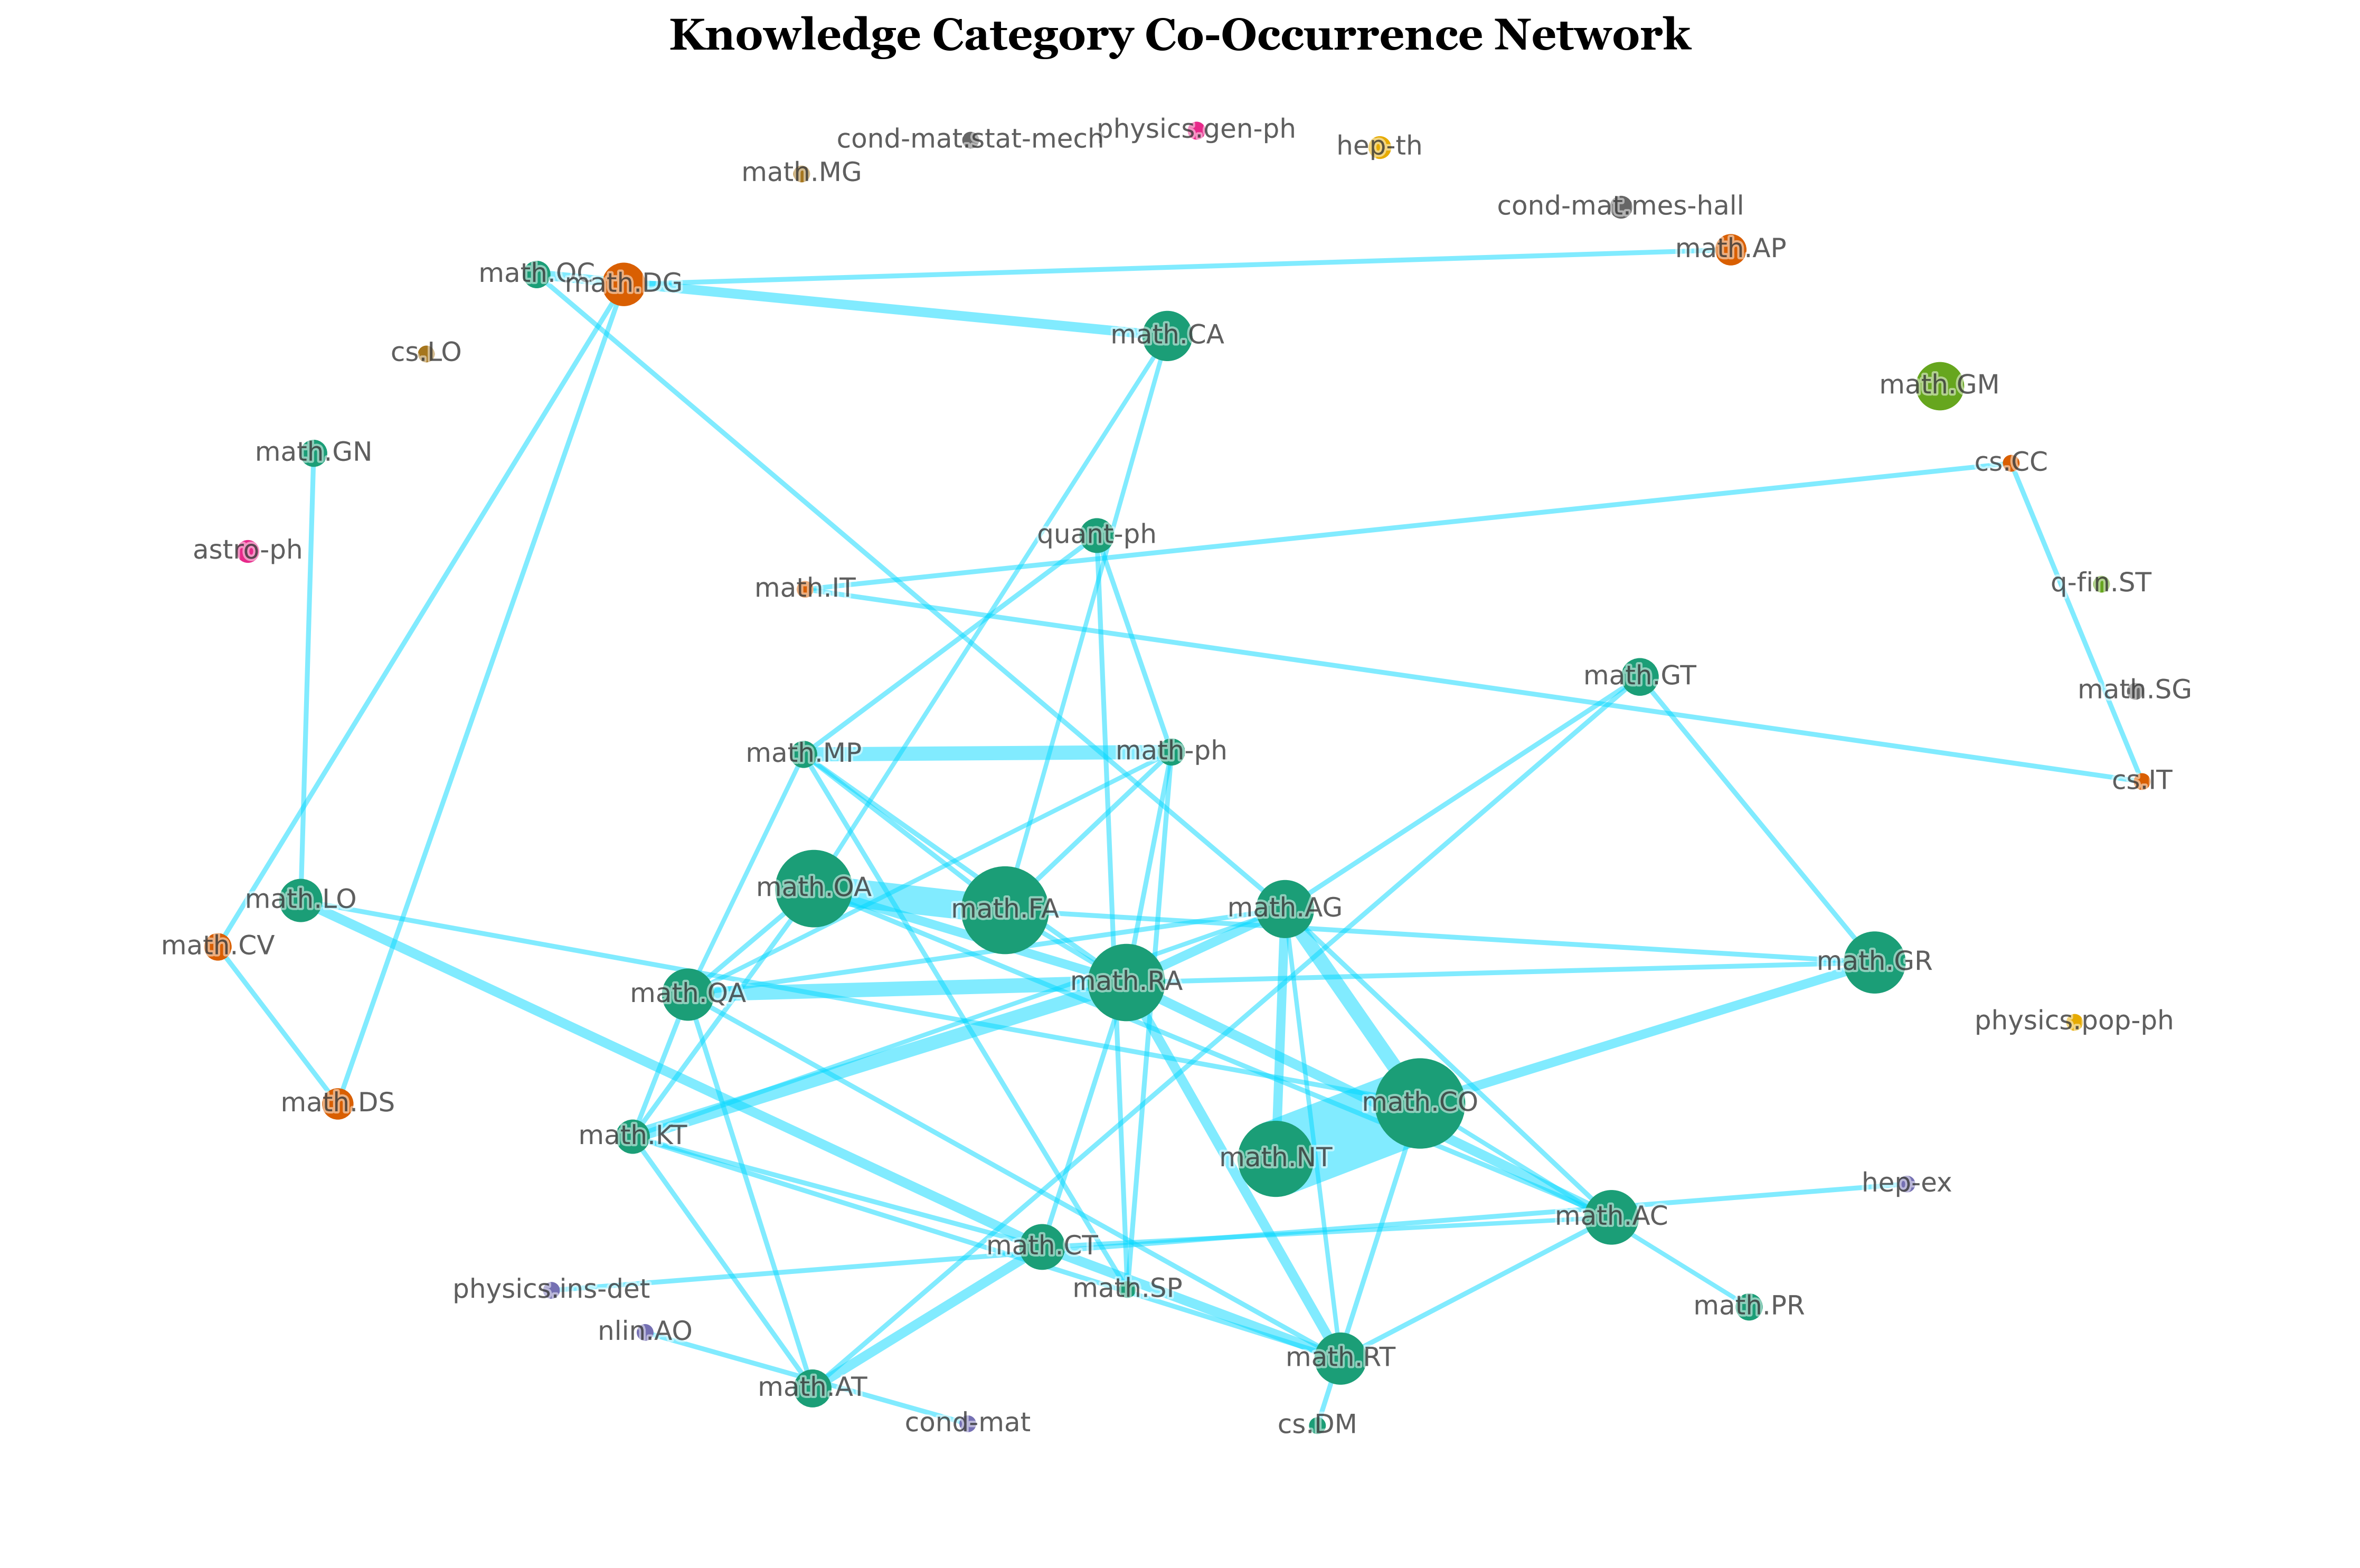

In [143]:
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe

# Position nodes with force-directed layout
pos = nx.spring_layout(G, seed=42, k=50, iterations=1000)

plt.figure(figsize=(15, 10), dpi=300)

# # Draw nodes with size based on frequency
# node_sizes = [G.nodes[n]['size'] * 20 for n in G.nodes]
# nx.draw_networkx_nodes(G, pos, node_size=node_sizes, alpha=0.5, node_color='#04d9ff')

# Highlight each community in a different color
communities_list = list(communities)
cmap = plt.cm.get_cmap('Dark2', len(communities_list))

for i, comm in enumerate(communities_list):
    nx.draw_networkx_nodes(
        G,
        pos,
        nodelist=list(comm),
        node_color=[cmap(i)],
        node_size=[G.nodes[n]['size'] * 200 / np.sqrt(total_papers) for n in comm],
        alpha=1
    )

# Draw edges with width based on co-occurrence frequency
edge_widths = [G[u][v]['weight'] * 10 / np.sqrt(total_papers) for u, v in G.edges]
nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5, edge_color='#04d9ff')

# Draw labels and apply stroke using path_effects
labels = nx.draw_networkx_labels(G, pos, font_size=12, alpha=0.5)
for label in labels.values():
	label.set_path_effects([pe.withStroke(linewidth=2, foreground='white', alpha=0.5)])

plt.title("Knowledge Category Co-Occurrence Network", fontsize=20, fontweight='bold', fontfamily='Georgia')
plt.axis('off')
plt.tight_layout()
plt.savefig("arxiv_category_network.png", dpi=300)
plt.show()

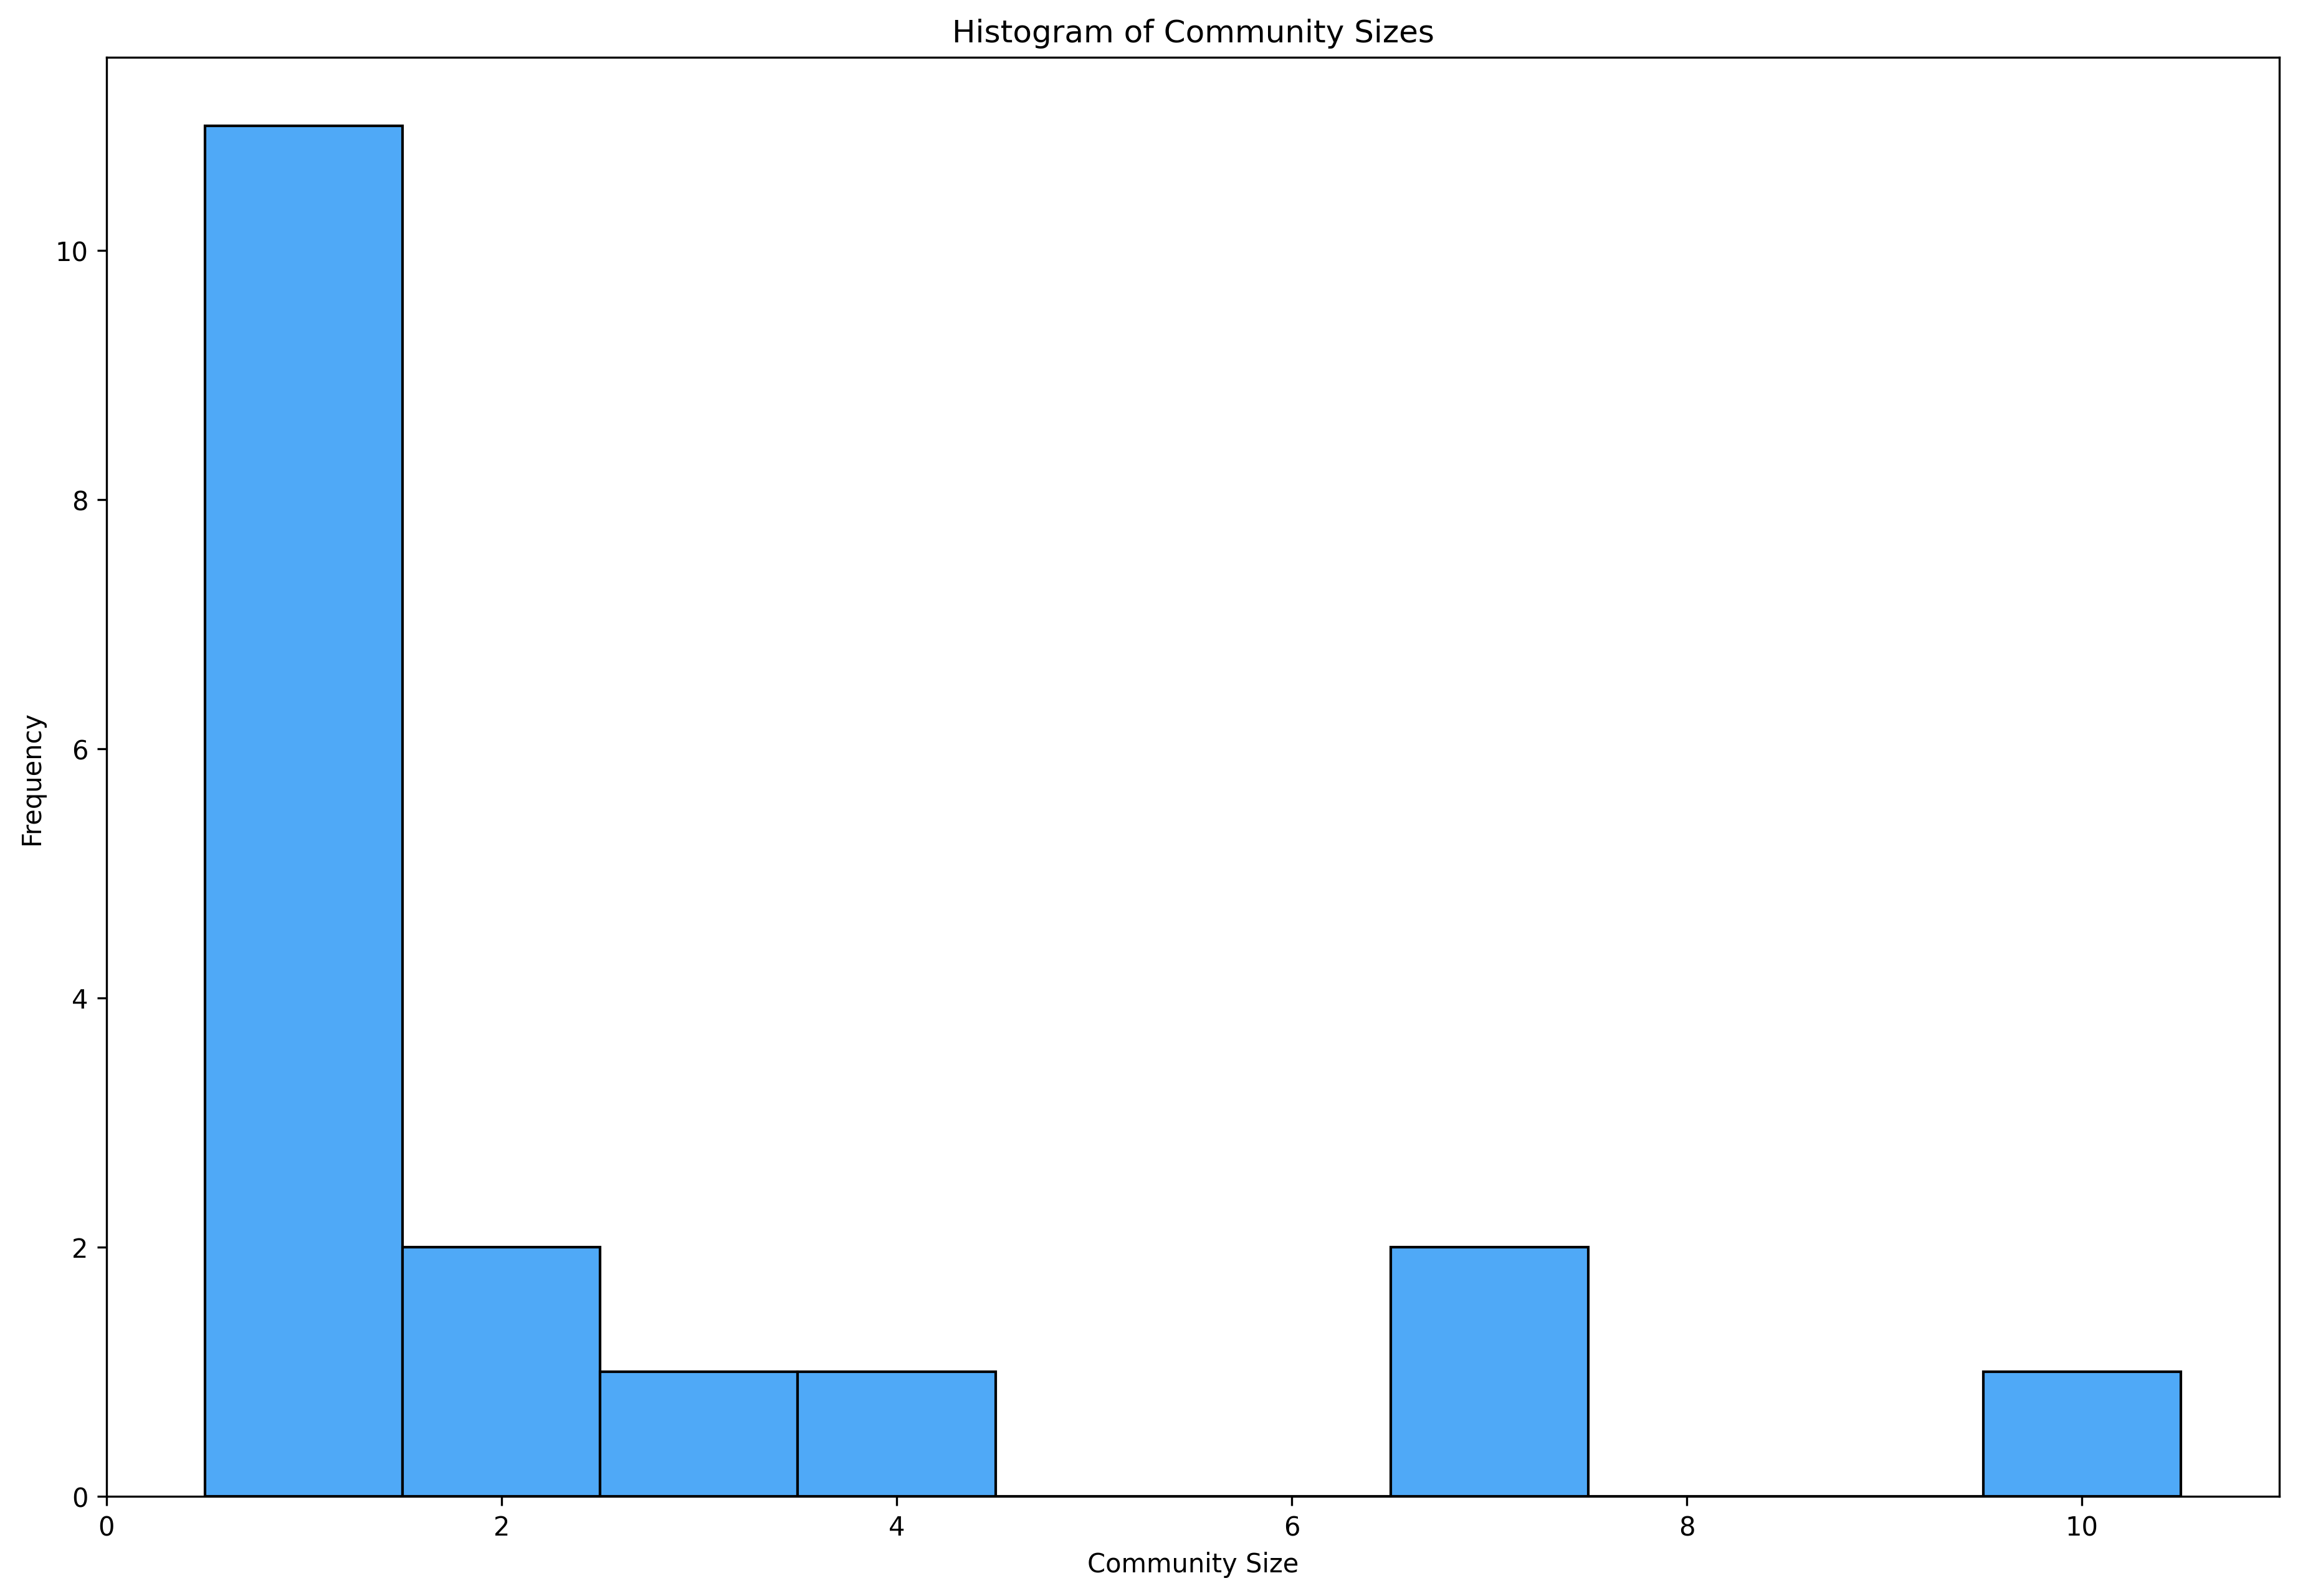

In [140]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10), dpi=300)

community_sizes = [len(comm) for comm in communities]
plt.hist(community_sizes, bins=range(1, max(community_sizes) + 2), align='left', color='#4fa9f7', edgecolor='black')
plt.xlabel('Community Size')
plt.ylabel('Frequency')
plt.title('Histogram of Community Sizes')
plt.show()